<a href="https://colab.research.google.com/github/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tiny Object Detection : Normalized Gaussian Wasserstein Distance (NWD)

This is an user implementation of Normalized Gaussian Wasserstein Distance for Tiny Object Detection(under review, https://arxiv.org/abs/2110.13389). This implementation includes 

- train Faster R-CNN on VisDrone2019 and AI-TOD using NWD.

Let's start!


In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
# it may take some time
!pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.5.0/index.html

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

# install Pillow 7.0.0 back in order to avoid bug in colab
# you can ignore when restart rutime warning appear
!pip install Pillow==7.0.0

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu101/torch1.5.0/index.html
Cloning into 'mmdetection'...
remote: Enumerating objects: 22552, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 22552 (delta 0), reused 1 (delta 0), pack-reused 22549
Receiving objects: 100% (22552/22552), 25.56 MiB | 24.21 MiB/s, done.
Resolving deltas: 100% (15784/15784), done.
/content/mmdetection
Obtaining file:///content/mmdetection
  Running setup.py develop for mmdet


In [3]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

from glob import glob
import os



1.5.1+cu101 True
2.19.1
10.1
GCC 7.3


### Dataset-1 : VisDrone2019

In [4]:
# If you have AI-TOD datset in your Google Drive, 
# simply connect to the Google Drive folder 

download_visdrone = False
if download_visdrone :
  # download, decompress the data
  # not completed yet.. 
  !wget https://drive.google.com/file/d/1a2oHjcEcwXP8oUF95qiwrqzACb2YlUhn/view?usp=sharing
else: 
  from google.colab import drive
  drive.mount('/content/drive/')
  data_root_dir = '/content/VisDrone2019/' # put your path to visdrone2019


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
# copy dataset from Google Drive to Colab working directory
!cp -r '/content/drive/MyDrive/dataset/#bench_marks/VisDrone2019' '/content/VisDrone2019'

In [6]:
# directory names for train, val and test set 
train_dir_name = 'VisDrone2019-DET-train'
val_dir_name = 'VisDrone2019-DET-val'
test_dir_name = 'VisDrone2019-DET-test-dev' # sample test images with ground truth 

train_dir = os.path.join(data_root_dir, train_dir_name)
val_dir = os.path.join(data_root_dir, val_dir_name)
test_dir = os.path.join(data_root_dir, test_dir_name)

train_img_list = glob(os.path.join(train_dir, 'images', "*.jpg"))
val_img_list = glob(os.path.join(val_dir, 'images', "*.jpg"))
test_img_list = glob(os.path.join(test_dir, 'images', "*.jpg"))

train_ann_list = glob(os.path.join(train_dir, 'annotations', "*.txt"))
val_ann_list = glob(os.path.join(val_dir, 'annotations', "*.txt"))
test_ann_list = glob(os.path.join(test_dir, 'annotations', "*.txt"))

print("Num of train images: {} ".format(len(train_img_list)))
print("Num of validation images: {} ".format(len(val_img_list)))
print("Num of test-dev images: {} ".format(len(test_img_list)))

Num of train images: 6471 
Num of validation images: 548 
Num of test-dev images: 1610 


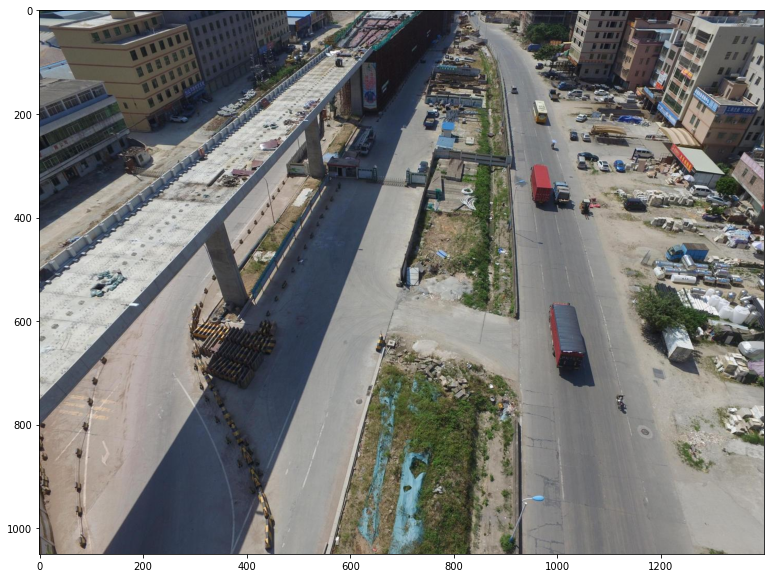

In [7]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt
import random 

# img_idx = 0 # set specific image index 
img_idx = random.randint(0, len(train_img_list)-1)

img = mmcv.imread(train_img_list[img_idx])
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

According to the VisDrone's documentation, the first four columns includes bbox information, and the 5th to 8th columns indicates score, object category, truncation and occlusion respectively. We need to read annotations of each image and convert them into middle format MMDetection accept is as below:

```python
[ <bbox_left>,<bbox_top>,<bbox_width>,<bbox_height>,<score>,<object_category>,<truncation>,<occlusion> ]
```

In [8]:
# Let's take a look at the dataset annotation format

# img_idx = 0 # set specific image index 
ann_idx = random.randint(0, len(train_img_list)-1)

ann_txt  = mmcv.list_from_file(train_ann_list[ann_idx]) # read a text file to list 

# please refer to annotation style at VisDrone2019 hompage : "http://aiskyeye.com/evaluate/results-format_2021/"

print('<bbox_left>,<bbox_top>,<bbox_width>,<bbox_height>,<score>,<object_category>,<truncation>,<occlusion>')
print(ann_txt[1])

<bbox_left>,<bbox_top>,<bbox_width>,<bbox_height>,<score>,<object_category>,<truncation>,<occlusion>
396,602,129,61,1,4,0,0


In [9]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset
from tqdm import tqdm

@DATASETS.register_module()
class VisDrone2019Dataset2(CustomDataset):

    """
    The object category indicates the type of annotated object, 
    (i.e., ignored regions  (0), pedestrian (1), people (2), bicycle (3), 
            car             (4), van        (5), truck  (6), tricycle (7),
            awning-tricycle (8), bus        (9), motor (10), others (11))
    """

    CLASSES = ('pedestrian', 'people', 'bicycle',
               'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 
               'bus', 'motor', 'others') # exclude ignored regions

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}

        data_infos = []
        image_list = glob(osp.join(self.data_root, self.img_prefix, '*jpg'))
        ann_dir = osp.join(self.data_root, self.ann_file)
        

        for image_dir in tqdm(image_list,  desc="Load annotations") : 
            image = mmcv.imread(image_dir)
            height, width = image.shape[:2]
            filename = image_dir.split('/')[-1]

            data_info = dict(filename=filename, width=width, height=height)

            # load annotations
            ann_txt = mmcv.list_from_file(osp.join(ann_dir, filename.replace('jpg', 'txt')))

            contents = [line.strip().split(',') for line in ann_txt]
            bbox_labels = [x[5] for x in contents]

            bboxes = []
            for content in contents : 
                x, y, w, h = content[0:4]
                x, y, w, h = float(x), float(y), float(w), float(h)
                bboxes.append([x, y, x+w, y+h])

            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []

            # filter 'DontCare'
            for bbox_label, bbox in zip(bbox_labels, bboxes):
                if bbox_label == '0':
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)
                else:
                    gt_labels.append(int(bbox_label)-1)
                    gt_bboxes.append(bbox)
                    
            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos      

    def evaluate(self,
                 results,
                 metric='mAP',
                 logger=None,
                 proposal_nums=(100, 300, 1000),
                 iou_thr=0.5,
                 scale_ranges=None):
        """Evaluate the dataset.
        Args:
            results (list): Testing results of the dataset.
            metric (str | list[str]): Metrics to be evaluated.
            logger (logging.Logger | None | str): Logger used for printing
                related information during evaluation. Default: None.
            proposal_nums (Sequence[int]): Proposal number used for evaluating
                recalls, such as recall@100, recall@1000.
                Default: (100, 300, 1000).
            iou_thr (float | list[float]): IoU threshold. Default: 0.5.
            scale_ranges (list[tuple] | None): Scale ranges for evaluating mAP.
                Default: None.
        """

        print("You are using this code.")

        if not isinstance(metric, str):
            assert len(metric) == 1
            metric = metric[0]
        allowed_metrics = ['mAP', 'recall']
        if metric not in allowed_metrics:
            raise KeyError(f'metric {metric} is not supported')

        annotations = [self.get_ann_info(i) for i in range(len(self))]
        eval_results = OrderedDict()
        iou_thrs = [iou_thr] if isinstance(iou_thr, float) else iou_thr
        

        if metric == 'mAP':
            assert isinstance(iou_thrs, list) 
            mean_aps = []
            if scale_ranges is None : 
                for iou_thr in iou_thrs:
                    print_log(f'\n{"-" * 15}iou_thr: {iou_thr}{"-" * 15}')
                    mean_ap, _ = eval_map(
                        results,
                        annotations,
                        scale_ranges=scale_ranges,
                        iou_thr=iou_thr,
                        dataset=self.CLASSES,
                        logger=logger)
                    mean_aps.append(mean_ap)
                    eval_results[f'AP{int(iou_thr * 100):02d}'] = round(mean_ap, 3)
                eval_results['mAP'] = sum(mean_aps) / len(mean_aps)
            elif isinstance(scale_ranges , list) : 
                mean_aps, _ = eval_map(
                        results,
                        annotations,
                        scale_ranges=scale_ranges,
                        iou_thr=iou_thr,
                        dataset=self.CLASSES,
                        logger=logger)
                eval_results['mAP'] = sum(mean_aps) / len(mean_aps)
                
        elif metric == 'recall':
            gt_bboxes = [ann['bboxes'] for ann in annotations]
            recalls = eval_recalls(
                gt_bboxes, results, proposal_nums, iou_thr, logger=logger)
            for i, num in enumerate(proposal_nums):
                for j, iou in enumerate(iou_thrs):
                    eval_results[f'recall@{num}@{iou}'] = recalls[i, j]
            if recalls.shape[1] > 1:
                ar = recalls.mean(axis=1)
                for i, num in enumerate(proposal_nums):
                    eval_results[f'AR@{num}'] = ar[i]
        return eval_results

### IoU-Deviation Curve and NWD-Deviation Curve Comparison 

In [10]:
from mmdet.core.bbox.iou_calculators.iou2d_calculator import bbox_overlaps


def collect_iou_calculation(scales,dev_range, center_x, center_y, bbox1_size_factor, bbox2_size_factor):
    bboxes1 = []
    bboxes2 = []
    overlap_cal_results = []
    for scale_idx, scale in enumerate(scales):
        width = bbox1_size_factor*scale 
        height = bbox1_size_factor*scale 
        x1, y1, x2, y2 = int(center_x-width/2), int(center_y-height/2), int(center_x+width/2), int(center_y+height/2)
        bbox1 = [x1, y1, x2, y2]

        bboxes1.append(bbox1)
        bboxes2.append([])

        for deviation in np.arange(dev_range[0], dev_range[-1]):
            width = bbox2_size_factor*scale 
            height = bbox2_size_factor*scale 
            x1, y1, x2, y2 = int(center_x-width/2), int(center_y-height/2), int(center_x+width/2), int(center_y+height/2)
            bbox2 =  [x1+deviation, y1+deviation, x2+deviation, y2+deviation]
            bboxes2[scale_idx].append(bbox2)
        
        bbox1_tensor = torch.FloatTensor([bbox1])
        bboxes2_tensor = torch.FloatTensor(bboxes2[scale_idx])
        

        overlap_cal_results.append(bbox_overlaps(bbox1_tensor, bboxes2_tensor)[0])

    return overlap_cal_results

In [11]:
from scipy.stats import wasserstein_distance
from numpy.linalg import norm 


def collect_nwd_calculation(scales, dev_range, center_x, center_y, bbox1_size_factor, bbox2_size_factor, c=1):
    bboxes1 = []
    bboxes2 = []
    overlap_cal_results = []
    for scale_idx, scale in enumerate(scales):
        overlap_cal_result = []
        width = bbox1_size_factor*scale 
        height = bbox1_size_factor*scale 
        bbox1 = [center_x, center_y, width/2, height/2]

        for deviation in np.arange(dev_range[0], dev_range[-1]):
            width = bbox2_size_factor*scale 
            height = bbox2_size_factor*scale 
            bbox2 =  [center_x+deviation, center_y+deviation, width/2, height/2]
            # w_dist = wasserstein_distance(bbox1, bbox2) # scipy implementation may differ to paper's Wasserstein distance
            w_dist = np.sqrt((bbox1[0]-bbox2[0])**2 + (bbox1[1]-bbox2[1])**2 + (bbox1[2]-bbox2[2])**2 + (bbox1[3]-bbox2[3])**2)
            nwd = np.exp(-np.sqrt(w_dist**2)/c)
            overlap_cal_result.append(nwd)


        overlap_cal_results.append(overlap_cal_result)

    return overlap_cal_results

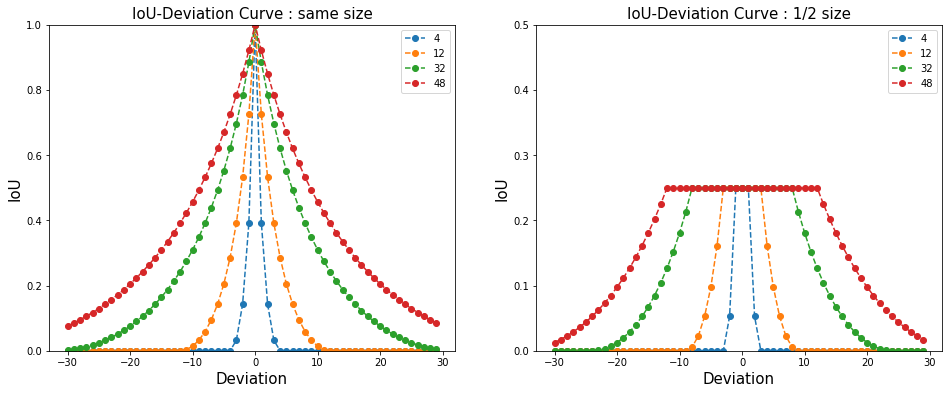

In [12]:
import matplotlib.pyplot as plt 

center_x, center_y = 256, 256
bbox1_size_factor = 1
bbox2_size_factor = [1, 0.5]
scales = [4, 12, 32, 48]
dev_range = [-30, 30]

overlap_cal_results_0 = collect_iou_calculation(scales,dev_range, center_x, center_y, bbox1_size_factor, bbox2_size_factor[0])
overlap_cal_results_1 = collect_iou_calculation(scales,dev_range, center_x, center_y, bbox1_size_factor, bbox2_size_factor[1])

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

for result in overlap_cal_results_0 : 
    axs[0].plot(np.arange(dev_range[0], dev_range[1]), result, 'o--')
    axs[0].set_xlabel('Deviation', fontsize=15)
    axs[0].set_ylabel('IoU', fontsize=15)
    axs[0].set_title('IoU-Deviation Curve : same size', fontsize=15)
    axs[0].set_ylim(0, 1.0)
    axs[0].legend(scales)


for result in overlap_cal_results_1 : 
    axs[1].plot(np.arange(dev_range[0], dev_range[1]), result, 'o--')
    axs[1].set_xlabel('Deviation', fontsize=15)
    axs[1].set_ylabel('IoU', fontsize=15)
    axs[1].set_title('IoU-Deviation Curve : 1/2 size', fontsize=15)
    axs[1].set_ylim(0, 0.5)
    axs[1].legend(scales)

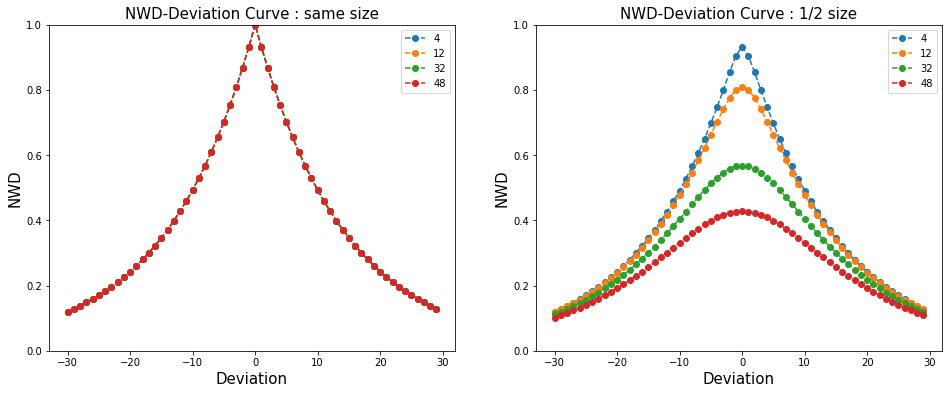

In [13]:
import matplotlib.pyplot as plt 

center_x, center_y = 256, 256
bbox1_size_factor = 1
bbox2_size_factor = [1, 0.5]
scales = [4, 12, 32, 48]
dev_range = [-30, 30]
c = 20
overlap_cal_results_0 = collect_nwd_calculation(scales,dev_range, center_x, center_y, bbox1_size_factor, bbox2_size_factor[0], c=c)
overlap_cal_results_1 = collect_nwd_calculation(scales,dev_range, center_x, center_y, bbox1_size_factor, bbox2_size_factor[1], c=c)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

for result in overlap_cal_results_0 : 
    axs[0].plot(np.arange(dev_range[0], dev_range[1]), result, 'o--')
    axs[0].set_xlabel('Deviation', fontsize=15)
    axs[0].set_ylabel('NWD', fontsize=15)
    axs[0].set_title('NWD-Deviation Curve : same size', fontsize=15)
    axs[0].set_ylim(0, 1.0)
    axs[0].legend(scales)


for result in overlap_cal_results_1 : 
    axs[1].plot(np.arange(dev_range[0], dev_range[1]), result, 'o--')
    axs[1].set_xlabel('Deviation', fontsize=15)
    axs[1].set_ylabel('NWD', fontsize=15)
    axs[1].set_title('NWD-Deviation Curve : 1/2 size', fontsize=15)
    axs[1].set_ylim(0, 1.0)
    axs[1].legend(scales)

In [14]:

def NWD_calculator(gt_bboxes, bboxes, c=20):
    NWD = torch.zeros(gt_bboxes.size(0), bboxes.size(0), device = gt_bboxes.get_device())
    
    for idx in range(4) :
        indices = torch.tensor([idx], device = gt_bboxes.get_device())
        NWD += (torch.index_select(gt_bboxes, 1, indices) - torch.index_select(bboxes, 1, indices).T)**2 
    
    NWD = torch.exp(-torch.sqrt(NWD)/c) 
    # print(torch.unique(NWD))
    
    return NWD


In [15]:
# NWD-based label assginment 

# mmdetection/mmdet/core/bbox/assigners/
from mmdet.core.bbox.builder import BBOX_ASSIGNERS
from mmdet.core.bbox.iou_calculators import build_iou_calculator
from mmdet.core.bbox.assigners.assign_result import AssignResult
from mmdet.core.bbox.assigners.base_assigner import BaseAssigner
from mmdet.core import eval_map, eval_recalls
from collections import OrderedDict
from mmcv.utils import print_log


@BBOX_ASSIGNERS.register_module()
class MaxNWDAssigner11(BaseAssigner):

    def __init__(self,
                 pos_iou_thr,
                 neg_iou_thr,
                 min_pos_iou=.0,
                 gt_max_assign_all=True,
                 ignore_iof_thr=-1,
                 ignore_wrt_candidates=True,
                 match_low_quality=True,
                 gpu_assign_thr=-1,
                 iou_calculator=dict(type='BboxOverlaps2D')):
        self.pos_iou_thr = pos_iou_thr
        self.neg_iou_thr = neg_iou_thr
        self.min_pos_iou = min_pos_iou
        self.gt_max_assign_all = gt_max_assign_all
        self.ignore_iof_thr = ignore_iof_thr
        self.ignore_wrt_candidates = ignore_wrt_candidates
        self.gpu_assign_thr = gpu_assign_thr
        self.match_low_quality = match_low_quality
        self.iou_calculator = build_iou_calculator(iou_calculator)

    def assign(self, bboxes, gt_bboxes, gt_bboxes_ignore=None, gt_labels=None):
       
        assign_on_cpu = True if (self.gpu_assign_thr > 0) and (
            gt_bboxes.shape[0] > self.gpu_assign_thr) else False
        # compute overlap and assign gt on CPU when number of GT is large
        if assign_on_cpu:
            device = bboxes.device
            bboxes = bboxes.cpu()
            gt_bboxes = gt_bboxes.cpu()
            if gt_bboxes_ignore is not None:
                gt_bboxes_ignore = gt_bboxes_ignore.cpu()
            if gt_labels is not None:
                gt_labels = gt_labels.cpu()
        # print(gt_bboxes.size())
        # print(bboxes.size())
        overlaps = NWD_calculator(gt_bboxes, bboxes)
        # overlaps = self.iou_calculator(gt_bboxes, bboxes)
        # print(overlaps.size())

        if (self.ignore_iof_thr > 0 and gt_bboxes_ignore is not None
                and gt_bboxes_ignore.numel() > 0 and bboxes.numel() > 0):
            if self.ignore_wrt_candidates:
                ignore_overlaps = self.iou_calculator(
                    bboxes, gt_bboxes_ignore, mode='iof')
                ignore_max_overlaps, _ = ignore_overlaps.max(dim=1)
            else:
                ignore_overlaps = self.iou_calculator(
                    gt_bboxes_ignore, bboxes, mode='iof')
                ignore_max_overlaps, _ = ignore_overlaps.max(dim=0)
            overlaps[:, ignore_max_overlaps > self.ignore_iof_thr] = -1

        assign_result = self.assign_wrt_overlaps(overlaps, gt_labels)
        if assign_on_cpu:
            assign_result.gt_inds = assign_result.gt_inds.to(device)
            assign_result.max_overlaps = assign_result.max_overlaps.to(device)
            if assign_result.labels is not None:
                assign_result.labels = assign_result.labels.to(device)
        return assign_result

    def assign_wrt_overlaps(self, overlaps, gt_labels=None):
        """Assign w.r.t. the overlaps of bboxes with gts.
        Args:
            overlaps (Tensor): Overlaps between k gt_bboxes and n bboxes,
                shape(k, n).
            gt_labels (Tensor, optional): Labels of k gt_bboxes, shape (k, ).
        Returns:
            :obj:`AssignResult`: The assign result.
        """
        num_gts, num_bboxes = overlaps.size(0), overlaps.size(1)

        # 1. assign -1 by default
        assigned_gt_inds = overlaps.new_full((num_bboxes, ),
                                             -1,
                                             dtype=torch.long)

        if num_gts == 0 or num_bboxes == 0:
            # No ground truth or boxes, return empty assignment
            max_overlaps = overlaps.new_zeros((num_bboxes, ))
            if num_gts == 0:
                # No truth, assign everything to background
                assigned_gt_inds[:] = 0
            if gt_labels is None:
                assigned_labels = None
            else:
                assigned_labels = overlaps.new_full((num_bboxes, ),
                                                    -1,
                                                    dtype=torch.long)
            return AssignResult(
                num_gts,
                assigned_gt_inds,
                max_overlaps,
                labels=assigned_labels)

        # for each anchor, which gt best overlaps with it
        # for each anchor, the max iou of all gts
        max_overlaps, argmax_overlaps = overlaps.max(dim=0)
        # for each gt, which anchor best overlaps with it
        # for each gt, the max iou of all proposals
        gt_max_overlaps, gt_argmax_overlaps = overlaps.max(dim=1)

        # 2. assign negative: below
        # the negative inds are set to be 0
        if isinstance(self.neg_iou_thr, float):
            assigned_gt_inds[(max_overlaps >= 0)
                             & (max_overlaps < self.neg_iou_thr)] = 0
        elif isinstance(self.neg_iou_thr, tuple):
            assert len(self.neg_iou_thr) == 2
            assigned_gt_inds[(max_overlaps >= self.neg_iou_thr[0])
                             & (max_overlaps < self.neg_iou_thr[1])] = 0

        # 3. assign positive: above positive IoU threshold
        pos_inds = max_overlaps >= self.pos_iou_thr
        assigned_gt_inds[pos_inds] = argmax_overlaps[pos_inds] + 1

        if self.match_low_quality:
            # Low-quality matching will overwrite the assigned_gt_inds assigned
            # in Step 3. Thus, the assigned gt might not be the best one for
            # prediction.
            # For example, if bbox A has 0.9 and 0.8 iou with GT bbox 1 & 2,
            # bbox 1 will be assigned as the best target for bbox A in step 3.
            # However, if GT bbox 2's gt_argmax_overlaps = A, bbox A's
            # assigned_gt_inds will be overwritten to be bbox B.
            # This might be the reason that it is not used in ROI Heads.
            for i in range(num_gts):
                if gt_max_overlaps[i] >= self.min_pos_iou:
                    if self.gt_max_assign_all:
                        max_iou_inds = overlaps[i, :] == gt_max_overlaps[i]
                        assigned_gt_inds[max_iou_inds] = i + 1
                    else:
                        assigned_gt_inds[gt_argmax_overlaps[i]] = i + 1

        if gt_labels is not None:
            assigned_labels = assigned_gt_inds.new_full((num_bboxes, ), -1)
            pos_inds = torch.nonzero(
                assigned_gt_inds > 0, as_tuple=False).squeeze()
            if pos_inds.numel() > 0:
                assigned_labels[pos_inds] = gt_labels[
                    assigned_gt_inds[pos_inds] - 1]
        else:
            assigned_labels = None

        return AssignResult(
            num_gts, assigned_gt_inds, max_overlaps, labels=assigned_labels)
        

    

In [16]:
# NWD-based NMS 
# https://github.com/open-mmlab/mmcv/blob/master/mmcv/ops/nms.py

In [17]:
# NWD-based regression loss 
# mmdetection/mmdet/models/losses/

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [18]:
from mmcv import Config
cfg = Config.fromfile('configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')

In [19]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'VisDrone2019Dataset2'
cfg.data_root = data_root_dir

cfg.data.test.type = 'VisDrone2019Dataset2'
cfg.data.test.data_root = '{}/{}/'.format(data_root_dir, test_dir_name) 
cfg.data.test.ann_file = 'annotations'
cfg.data.test.img_prefix = 'images'

cfg.data.train.type = 'VisDrone2019Dataset2'
cfg.data.train.data_root = '{}/{}/'.format(data_root_dir, train_dir_name) 
cfg.data.train.ann_file = 'annotations'
cfg.data.train.img_prefix = 'images'

cfg.data.val.type = 'VisDrone2019Dataset2'
cfg.data.val.data_root = '{}/{}/'.format(data_root_dir, val_dir_name) 
cfg.data.val.ann_file = 'annotations'
cfg.data.val.img_prefix = 'images'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 11 # exclude ignored regions

cfg.model.train_cfg.rpn.assigner.type = 'MaxNWDAssigner11'
cfg.model.train_cfg.rcnn.assigner.type = 'MaxNWDAssigner11'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 500

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 1
cfg.evaluation.scale_ranges = [(1, 32), (32, 96), (96, 2000)]
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe',
        init_cfg=dict(
            type='Pretrained',
            checkpoint='open-mmlab://detectron2/resnet50_caffe')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='Cro

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [20]:
# download checkpoint file 
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth \
      -O checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth

--2021-12-29 06:03:55--  https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.186.233
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.186.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177867103 (170M) [application/octet-stream]
Saving to: ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’

checkpoints/mask_rc 100%[===================>] 169.63M  10.5MB/s    in 18s     

2021-12-29 06:04:14 (9.40 MB/s) - ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’ saved [177867103/177867103]



In [21]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# Build dataset
datasets = [build_dataset(cfg.data.train)] # should take a long time if google drive is used....

Load annotations: 100%|██████████| 6471/6471 [01:58<00:00, 54.76it/s]
/content/mmdetection/mmdet/datasets/custom.py:178: UserWarning: CustomDataset does not support filtering empty gt images.
  'CustomDataset does not support filtering empty gt images.')


In [22]:
# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)


Load annotations: 100%|██████████| 548/548 [00:06<00:00, 89.41it/s]
2021-12-29 06:06:20,903 - mmdet - INFO - load checkpoint from local path: checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
2021-12-29 06:06:21,027 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([12, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([12]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([44, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 548/548, 12.7 task/s, elapsed: 43s, ETA:     0sYou are using this code.


2021-12-29 06:24:29,946 - mmdet - INFO - Scale range (1, 1024)
2021-12-29 06:24:29,950 - mmdet - INFO - 
+-----------------+------+-------+--------+-------+
| class           | gts  | dets  | recall | ap    |
+-----------------+------+-------+--------+-------+
| pedestrian      | 7746 | 16625 | 0.519  | 0.379 |
| people          | 4631 | 5310  | 0.377  | 0.265 |
| bicycle         | 1053 | 2382  | 0.167  | 0.047 |
| car             | 6902 | 19638 | 0.657  | 0.545 |
| van             | 936  | 2495  | 0.204  | 0.075 |
| truck           | 289  | 913   | 0.166  | 0.092 |
| tricycle        | 620  | 259   | 0.074  | 0.047 |
| awning-tricycle | 305  | 65    | 0.030  | 0.013 |
| bus             | 116  | 280   | 0.026  | 0.006 |
| motor           | 3977 | 4055  | 0.365  | 0.253 |
| others          | 13   | 1     | 0.000  | 0.000 |
+-----------------+------+-------+--------+-------+
| mAP             |      |       |        | 0.157 |
+-----------------+------+-------+--------+-------+
2021-12-29 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 548/548, 12.7 task/s, elapsed: 43s, ETA:     0sYou are using this code.


2021-12-29 06:42:39,616 - mmdet - INFO - Scale range (1, 1024)
2021-12-29 06:42:39,619 - mmdet - INFO - 
+-----------------+------+-------+--------+-------+
| class           | gts  | dets  | recall | ap    |
+-----------------+------+-------+--------+-------+
| pedestrian      | 7746 | 10143 | 0.453  | 0.373 |
| people          | 4631 | 7368  | 0.481  | 0.336 |
| bicycle         | 1053 | 1285  | 0.172  | 0.087 |
| car             | 6902 | 20003 | 0.704  | 0.597 |
| van             | 936  | 2219  | 0.216  | 0.114 |
| truck           | 289  | 1733  | 0.336  | 0.164 |
| tricycle        | 620  | 378   | 0.118  | 0.073 |
| awning-tricycle | 305  | 223   | 0.095  | 0.045 |
| bus             | 116  | 330   | 0.241  | 0.146 |
| motor           | 3977 | 6719  | 0.546  | 0.404 |
| others          | 13   | 4     | 0.000  | 0.000 |
+-----------------+------+-------+--------+-------+
| mAP             |      |       |        | 0.213 |
+-----------------+------+-------+--------+-------+
2021-12-29 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 548/548, 12.7 task/s, elapsed: 43s, ETA:     0sYou are using this code.


2021-12-29 07:00:52,013 - mmdet - INFO - Scale range (1, 1024)
2021-12-29 07:00:52,016 - mmdet - INFO - 
+-----------------+------+-------+--------+-------+
| class           | gts  | dets  | recall | ap    |
+-----------------+------+-------+--------+-------+
| pedestrian      | 7746 | 12466 | 0.522  | 0.412 |
| people          | 4631 | 6988  | 0.495  | 0.351 |
| bicycle         | 1053 | 1424  | 0.182  | 0.100 |
| car             | 6902 | 19369 | 0.698  | 0.602 |
| van             | 936  | 3013  | 0.317  | 0.161 |
| truck           | 289  | 2016  | 0.349  | 0.174 |
| tricycle        | 620  | 528   | 0.176  | 0.118 |
| awning-tricycle | 305  | 344   | 0.161  | 0.063 |
| bus             | 116  | 411   | 0.336  | 0.222 |
| motor           | 3977 | 5967  | 0.552  | 0.424 |
| others          | 13   | 8     | 0.000  | 0.000 |
+-----------------+------+-------+--------+-------+
| mAP             |      |       |        | 0.239 |
+-----------------+------+-------+--------+-------+
2021-12-29 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 548/548, 12.7 task/s, elapsed: 43s, ETA:     0sYou are using this code.


2021-12-29 07:19:02,013 - mmdet - INFO - Scale range (1, 1024)
2021-12-29 07:19:02,016 - mmdet - INFO - 
+-----------------+------+-------+--------+-------+
| class           | gts  | dets  | recall | ap    |
+-----------------+------+-------+--------+-------+
| pedestrian      | 7746 | 13290 | 0.538  | 0.418 |
| people          | 4631 | 6212  | 0.468  | 0.350 |
| bicycle         | 1053 | 1784  | 0.234  | 0.103 |
| car             | 6902 | 16316 | 0.678  | 0.576 |
| van             | 936  | 4420  | 0.408  | 0.194 |
| truck           | 289  | 1632  | 0.329  | 0.154 |
| tricycle        | 620  | 793   | 0.226  | 0.141 |
| awning-tricycle | 305  | 259   | 0.151  | 0.072 |
| bus             | 116  | 489   | 0.336  | 0.202 |
| motor           | 3977 | 6118  | 0.544  | 0.415 |
| others          | 13   | 20    | 0.000  | 0.000 |
+-----------------+------+-------+--------+-------+
| mAP             |      |       |        | 0.239 |
+-----------------+------+-------+--------+-------+
2021-12-29 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 548/548, 12.8 task/s, elapsed: 43s, ETA:     0sYou are using this code.


2021-12-29 07:37:12,847 - mmdet - INFO - Scale range (1, 1024)
2021-12-29 07:37:12,850 - mmdet - INFO - 
+-----------------+------+-------+--------+-------+
| class           | gts  | dets  | recall | ap    |
+-----------------+------+-------+--------+-------+
| pedestrian      | 7746 | 13374 | 0.518  | 0.406 |
| people          | 4631 | 8626  | 0.530  | 0.389 |
| bicycle         | 1053 | 1417  | 0.193  | 0.083 |
| car             | 6902 | 17829 | 0.701  | 0.607 |
| van             | 936  | 1764  | 0.235  | 0.151 |
| truck           | 289  | 617   | 0.194  | 0.096 |
| tricycle        | 620  | 791   | 0.226  | 0.129 |
| awning-tricycle | 305  | 289   | 0.161  | 0.069 |
| bus             | 116  | 83    | 0.078  | 0.043 |
| motor           | 3977 | 6803  | 0.598  | 0.443 |
| others          | 13   | 1     | 0.000  | 0.000 |
+-----------------+------+-------+--------+-------+
| mAP             |      |       |        | 0.220 |
+-----------------+------+-------+--------+-------+
2021-12-29 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 548/548, 12.7 task/s, elapsed: 43s, ETA:     0sYou are using this code.


2021-12-29 07:55:24,219 - mmdet - INFO - Scale range (1, 1024)
2021-12-29 07:55:24,223 - mmdet - INFO - 
+-----------------+------+-------+--------+-------+
| class           | gts  | dets  | recall | ap    |
+-----------------+------+-------+--------+-------+
| pedestrian      | 7746 | 9392  | 0.477  | 0.401 |
| people          | 4631 | 7356  | 0.516  | 0.381 |
| bicycle         | 1053 | 2373  | 0.281  | 0.127 |
| car             | 6902 | 18637 | 0.707  | 0.600 |
| van             | 936  | 3514  | 0.347  | 0.210 |
| truck           | 289  | 2039  | 0.394  | 0.192 |
| tricycle        | 620  | 1062  | 0.308  | 0.198 |
| awning-tricycle | 305  | 452   | 0.193  | 0.089 |
| bus             | 116  | 413   | 0.397  | 0.252 |
| motor           | 3977 | 6125  | 0.566  | 0.443 |
| others          | 13   | 18    | 0.000  | 0.000 |
+-----------------+------+-------+--------+-------+
| mAP             |      |       |        | 0.263 |
+-----------------+------+-------+--------+-------+
2021-12-29 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 548/548, 12.7 task/s, elapsed: 43s, ETA:     0sYou are using this code.


2021-12-29 08:13:34,518 - mmdet - INFO - Scale range (1, 1024)
2021-12-29 08:13:34,521 - mmdet - INFO - 
+-----------------+------+-------+--------+-------+
| class           | gts  | dets  | recall | ap    |
+-----------------+------+-------+--------+-------+
| pedestrian      | 7746 | 9723  | 0.491  | 0.412 |
| people          | 4631 | 6205  | 0.482  | 0.371 |
| bicycle         | 1053 | 1570  | 0.194  | 0.084 |
| car             | 6902 | 16664 | 0.707  | 0.610 |
| van             | 936  | 3604  | 0.407  | 0.230 |
| truck           | 289  | 1166  | 0.280  | 0.145 |
| tricycle        | 620  | 1161  | 0.253  | 0.166 |
| awning-tricycle | 305  | 547   | 0.226  | 0.087 |
| bus             | 116  | 541   | 0.293  | 0.208 |
| motor           | 3977 | 11315 | 0.662  | 0.484 |
| others          | 13   | 6     | 0.000  | 0.000 |
+-----------------+------+-------+--------+-------+
| mAP             |      |       |        | 0.254 |
+-----------------+------+-------+--------+-------+
2021-12-29 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 548/548, 12.7 task/s, elapsed: 43s, ETA:     0sYou are using this code.


2021-12-29 08:31:43,018 - mmdet - INFO - Scale range (1, 1024)
2021-12-29 08:31:43,022 - mmdet - INFO - 
+-----------------+------+-------+--------+-------+
| class           | gts  | dets  | recall | ap    |
+-----------------+------+-------+--------+-------+
| pedestrian      | 7746 | 13416 | 0.555  | 0.444 |
| people          | 4631 | 4913  | 0.454  | 0.360 |
| bicycle         | 1053 | 1819  | 0.253  | 0.120 |
| car             | 6902 | 15895 | 0.702  | 0.611 |
| van             | 936  | 3661  | 0.420  | 0.240 |
| truck           | 289  | 1645  | 0.377  | 0.175 |
| tricycle        | 620  | 1337  | 0.348  | 0.221 |
| awning-tricycle | 305  | 652   | 0.272  | 0.107 |
| bus             | 116  | 429   | 0.319  | 0.221 |
| motor           | 3977 | 6515  | 0.571  | 0.446 |
| others          | 13   | 13    | 0.000  | 0.000 |
+-----------------+------+-------+--------+-------+
| mAP             |      |       |        | 0.268 |
+-----------------+------+-------+--------+-------+
2021-12-29 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 548/548, 12.7 task/s, elapsed: 43s, ETA:     0sYou are using this code.


2021-12-29 08:49:50,688 - mmdet - INFO - Scale range (1, 1024)
2021-12-29 08:49:50,691 - mmdet - INFO - 
+-----------------+------+-------+--------+-------+
| class           | gts  | dets  | recall | ap    |
+-----------------+------+-------+--------+-------+
| pedestrian      | 7746 | 11696 | 0.549  | 0.453 |
| people          | 4631 | 6481  | 0.519  | 0.399 |
| bicycle         | 1053 | 1768  | 0.267  | 0.141 |
| car             | 6902 | 17639 | 0.734  | 0.645 |
| van             | 936  | 2841  | 0.387  | 0.246 |
| truck           | 289  | 1379  | 0.360  | 0.197 |
| tricycle        | 620  | 1096  | 0.334  | 0.219 |
| awning-tricycle | 305  | 492   | 0.259  | 0.107 |
| bus             | 116  | 469   | 0.414  | 0.318 |
| motor           | 3977 | 5519  | 0.579  | 0.469 |
| others          | 13   | 18    | 0.000  | 0.000 |
+-----------------+------+-------+--------+-------+
| mAP             |      |       |        | 0.291 |
+-----------------+------+-------+--------+-------+
2021-12-29 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 548/548, 12.7 task/s, elapsed: 43s, ETA:     0sYou are using this code.


2021-12-29 09:07:59,898 - mmdet - INFO - Scale range (1, 1024)
2021-12-29 09:07:59,901 - mmdet - INFO - 
+-----------------+------+-------+--------+-------+
| class           | gts  | dets  | recall | ap    |
+-----------------+------+-------+--------+-------+
| pedestrian      | 7746 | 11995 | 0.558  | 0.454 |
| people          | 4631 | 5944  | 0.506  | 0.394 |
| bicycle         | 1053 | 2049  | 0.291  | 0.148 |
| car             | 6902 | 17514 | 0.736  | 0.645 |
| van             | 936  | 2853  | 0.386  | 0.250 |
| truck           | 289  | 1528  | 0.346  | 0.188 |
| tricycle        | 620  | 1015  | 0.339  | 0.223 |
| awning-tricycle | 305  | 491   | 0.256  | 0.107 |
| bus             | 116  | 461   | 0.431  | 0.329 |
| motor           | 3977 | 5644  | 0.588  | 0.475 |
| others          | 13   | 23    | 0.000  | 0.000 |
+-----------------+------+-------+--------+-------+
| mAP             |      |       |        | 0.292 |
+-----------------+------+-------+--------+-------+
2021-12-29 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 548/548, 12.7 task/s, elapsed: 43s, ETA:     0sYou are using this code.


2021-12-29 09:26:08,223 - mmdet - INFO - Scale range (1, 1024)
2021-12-29 09:26:08,227 - mmdet - INFO - 
+-----------------+------+-------+--------+-------+
| class           | gts  | dets  | recall | ap    |
+-----------------+------+-------+--------+-------+
| pedestrian      | 7746 | 11779 | 0.547  | 0.447 |
| people          | 4631 | 6052  | 0.502  | 0.390 |
| bicycle         | 1053 | 1978  | 0.287  | 0.151 |
| car             | 6902 | 17701 | 0.741  | 0.644 |
| van             | 936  | 2897  | 0.393  | 0.254 |
| truck           | 289  | 1180  | 0.346  | 0.184 |
| tricycle        | 620  | 1054  | 0.347  | 0.229 |
| awning-tricycle | 305  | 477   | 0.246  | 0.100 |
| bus             | 116  | 407   | 0.440  | 0.334 |
| motor           | 3977 | 5954  | 0.596  | 0.480 |
| others          | 13   | 17    | 0.000  | 0.000 |
+-----------------+------+-------+--------+-------+
| mAP             |      |       |        | 0.292 |
+-----------------+------+-------+--------+-------+
2021-12-29 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 548/548, 12.7 task/s, elapsed: 43s, ETA:     0sYou are using this code.


2021-12-29 09:44:18,032 - mmdet - INFO - Scale range (1, 1024)
2021-12-29 09:44:18,035 - mmdet - INFO - 
+-----------------+------+-------+--------+-------+
| class           | gts  | dets  | recall | ap    |
+-----------------+------+-------+--------+-------+
| pedestrian      | 7746 | 11578 | 0.549  | 0.449 |
| people          | 4631 | 6289  | 0.512  | 0.394 |
| bicycle         | 1053 | 1851  | 0.288  | 0.150 |
| car             | 6902 | 17512 | 0.739  | 0.647 |
| van             | 936  | 3035  | 0.404  | 0.258 |
| truck           | 289  | 1319  | 0.363  | 0.191 |
| tricycle        | 620  | 1158  | 0.360  | 0.236 |
| awning-tricycle | 305  | 486   | 0.256  | 0.103 |
| bus             | 116  | 391   | 0.422  | 0.324 |
| motor           | 3977 | 5683  | 0.591  | 0.479 |
| others          | 13   | 20    | 0.000  | 0.000 |
+-----------------+------+-------+--------+-------+
| mAP             |      |       |        | 0.294 |
+-----------------+------+-------+--------+-------+
2021-12-29 